In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
import json, shutil, random
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from PIL import Image, ImageDraw
import torch
lt.monkey_patch()

sys.path.append("../../src")
from musubi_tuner.fpack_1fmc_generate import FramePack_1fmc
from musubi_tuner.frame_pack.hunyuan_video_packed import attn_cache
from musubi_tuner.utils.preproc_utils import getres, get_info_from_vistorybench, parse_bodylayout
from musubi_tuner.utils.viz_utils import convert_result_to_df_wpose, annot_viz, draw_final_img
from musubi_tuner.utils.attn_utils import get_img_attn_map

/u/ykwon4/.conda/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/u/ykwon4/.conda/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:Xformers is not installed!
INFO:root:Flash Attn is not installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention
model_path is /projects/bffz/ykwon4/musubi-tuner/src/practice/../../src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /projects/bffz/ykwon4/musubi-tuner/src/practice/../../src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/u/ykwon4/.conda/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u/ykwon4/.conda/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [2]:
framepack_model = FramePack_1fmc(
    dit_path = "/projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors",
    vae_path = "/projects/bffz/ykwon4/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt",
    text_encoder1_path = "/projects/bffz/ykwon4/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors",
    text_encoder2_path = "/projects/bffz/ykwon4/ComfyUI/models/text_encoders/clip_l.safetensors",
    lora_path = "/work/nvme/bffz/ykwon4/musubi-training/idmask_control_lora_wrope_v3_2/test1-step00005000.safetensors"
)
# framepack_model = FramePack_1fmc(
#     lora_path = "/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/outputs/training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3_multi-1-step00005000.safetensors"
# )

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda:0


INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /work/nvme/bffz/ykwon4/musubi-training/idmask_control_lora_wrope_v3_2/test1-step00005000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE model (884-16c-hy) from: /projects/bffz/ykwon4/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt
INFO:musubi_tuner.hunyuan_model.vae:VAE to dtype: torch.float16
INFO:musubi_tuner.fram

Model, VAE, Text Encoders, LoRA loaded.


### ViStoryBench

In [17]:
# sys.path.append("/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset
# vistory_dataset_path = Path("/groups/chenchen/patrick/ViStoryBench/dataset/ViStory")
vistory_dataset_path = Path("/projects/bffz/ykwon4/vistorybench/data/dataset/ViStory")
vistory_dataset = StoryDataset(vistory_dataset_path)

story_num = '02'
shot_num = 1

story = vistory_dataset.load_story(story_num)
story_dict = {x['index']:x for x in story['shots']}
vanila_shot, vanila_character_shot, _ = get_info_from_vistorybench(vistory_dataset, story_num, 1)

In [4]:
# main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20251107_132846_v2")
# main_layout_path = Path("/projects/bffz/ykwon4/vistorybench/data/gen_layouts_bulk/20250927_101053")
main_layout_path = Path("/projects/bffz/ykwon4/vistorybench/data/gen_layouts_bulk/20251107_132846_v2")

layouts = [
    (x.stem, list(map(int, x.stem.split("-pages_")[-1].split("_")))) 
    for x in  list(main_layout_path.glob(f"story_{story_num}*"))]
layout_name = [(x[0], x[1][0]) for x in layouts if shot_num in range(x[1][0], x[1][1]+1)][0]
author_output_dir = main_layout_path / layout_name[0]
layout = parse_bodylayout(author_output_dir / "pose_layout.json")
layout['[PANEL-2]'][1][1] = {'bbox' : [0.1, 0.5, 0.45, 0.99], 'body' : []}

In [18]:
shot_num = 3
story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = ";".join(prompt.split(";")[:4])
prompt = "Realistic, Science Fiction;Medium close up, eye level shot;Mr. Fogg slightly tilts his head, expression calm, Colonel Cromarty looks to the right at Mr. Fogg, expression serious"
print(prompt)
print("\n".join([f"{k} : {v['images']}" for k, v in characters_shot.items()]))


panel_bbox, panel_layout = layout[f'[PANEL-{shot_num-layout_name[1]+1}]']
# panel_layout = {0 : {'bbox' : [0.159, 0.4, 0.48, 0.98], 'body': []}, 1 : {'bbox': [0.559, 0.389, 0.879, 0.98], 'body': []}}
panel_width, panel_height = (panel_bbox[2]-panel_bbox[0])/1000*768, (panel_bbox[3]-panel_bbox[1])/1000*1024
width, height = getres(panel_width, panel_height, target_area=1344*768, max_aspect_ratio=2.5)

print((width, height))
print([v['bbox'] for _, v in panel_layout.items()])

Realistic, Science Fiction;Medium close up, eye level shot;Mr. Fogg slightly tilts his head, expression calm, Colonel Cromarty looks to the right at Mr. Fogg, expression serious
David : ['/projects/bffz/ykwon4/vistorybench/data/dataset/ViStory/02/image/David/00.jpg']
David's Mom : ["/projects/bffz/ykwon4/vistorybench/data/dataset/ViStory/02/image/David's Mom/00.jpg"]
(1072, 960)
[[0.102, 0.319, 0.709, 0.969]]


  0%|          | 0/25 [00:00<?, ?it/s]INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 5287, 3072] bf16 n=16241664 (31Mb) x∈[-16.750, 19.375] μ=-0.017 σ=0.949 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 43, 3072] bf16 n=132096 (0.3Mb) x∈[-1.400e+03, 474.000] μ=-0.005 σ=9.938 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.875, 19.375] μ=-0.108 σ=0.934 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 5330, 5330] bf16 n=28408900 (54Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 5287, 256] n=1353472 (5.2Mb) x∈[-1.000, 1.000] μ=0.303 σ=0.639 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 4087, 256] n=1046272 (4.0Mb) x∈[-1.000, 1.000] μ=0.306 σ=0.637 cuda:0, tensor[1, 400, 256] n=102400 (0.4Mb) x∈[-1.000, 1.000] μ=0.264 σ=0.656 cuda:0, tensor[1, 400, 256] n=102400 (0.4Mb) x∈[-1.000, 1.000] μ=0.307 σ=0.637 cuda:0, tensor[1, 400, 256] n=102400 (0.4Mb) x∈[-1.000,

100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


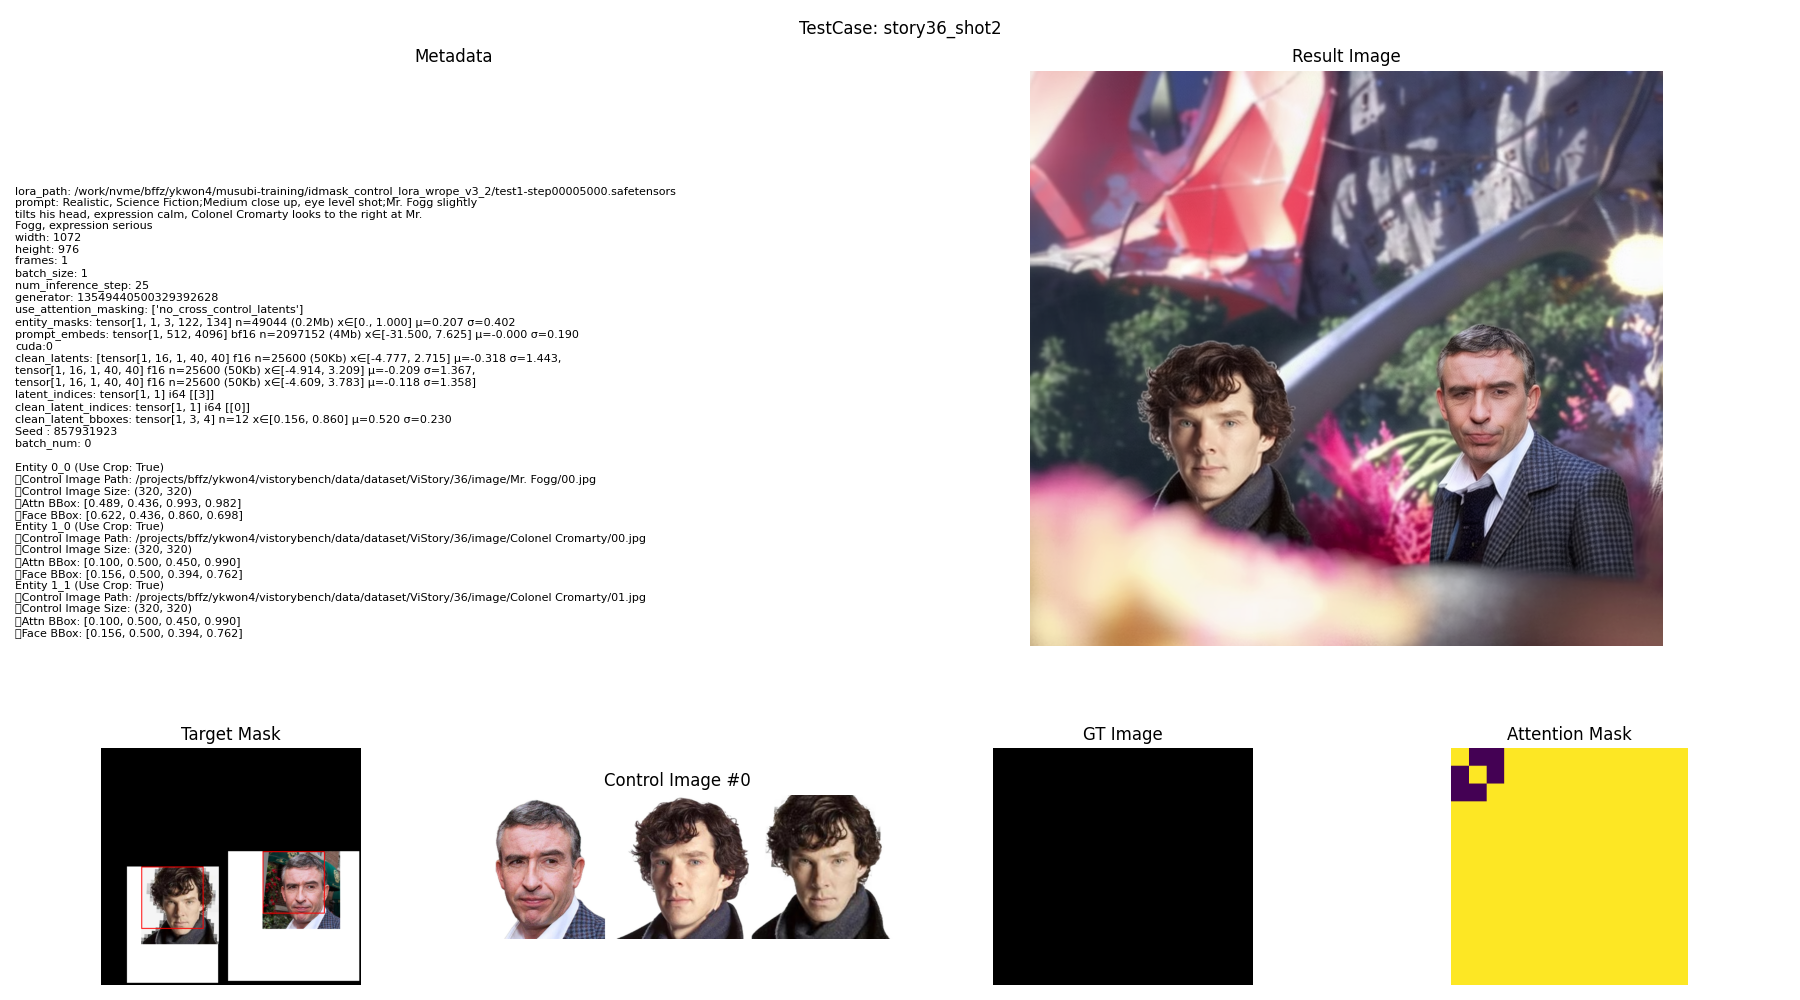

In [ ]:
seed = np.random.randint(2**31) #1174730479, 2085107311
# seed = 1017027825

result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt, panel_layout, characters_shot, width, height,
    c_width_given=256, seed=seed, crop_face_detect=True, use_rembg=True,
    cache_results=True, cache_layers=['transformer_blocks.2'], 
    use_attention_masking=['no_cross_control_latents'], 
    control_indices=[0], latent_indices=[3], max_chara=5,
    debug_name=f"story{story_num}_shot{shot_num}"
)

debug_imgs[0]

# result_imgs[0].save(f"tmp/{story_num}/{shot_num-1}_0.png")
# debug_imgs[0].save(f"tmp/{story_num}/debug/{shot_num-1}_0.png")

In [ ]:
result_imgs[0]

In [ ]:
# color_dict = {
#     0 : {'outline' : "#F2AA84", 'fill' : "#F6C6AD"},
#     1 : {'outline' : "#47D45A", 'fill' : "#84E291"},
#     2 : {'outline' : "#4E95D9", 'fill' : '#A6CAEC'}
# }
# layout_w, layout_h = 768, 1024
# layout_img = Image.new("RGB", (layout_w, layout_h), "WHITE")
# layout_draw = ImageDraw.Draw(layout_img)

# for panel_id, (panel_bbox, panel_layout) in layout.items():
#     panel_bbox = [
#         panel_bbox[0]/1000*layout_w, panel_bbox[1]/1000*layout_h,
#         panel_bbox[2]/1000*layout_w, panel_bbox[3]/1000*layout_h,
#     ]
#     layout_draw.rectangle(panel_bbox, outline=(0,0,0), width=4)
#     panel_layout = [
#         [
#             max(x['bbox'][0], 0.02)*(panel_bbox[2]-panel_bbox[0])+panel_bbox[0], max(x['bbox'][1], 0.02)*(panel_bbox[2]-panel_bbox[0])+panel_bbox[1],
#             min(x['bbox'][2], 0.98)*(panel_bbox[2]-panel_bbox[0])+panel_bbox[0], min(x['bbox'][3], 0.98)*(panel_bbox[3]-panel_bbox[1])+panel_bbox[1],
#         ]
#         for _,x in panel_layout.items()]
#     for i, body_bbox in enumerate(panel_layout):
#         if panel_id in ['[PANEL-3]', '[PANEL-4]', '[PANEL-5]', '[PANEL-6]']:
#             i = 2
#         layout_draw.rectangle(body_bbox, outline=color_dict[i]['outline'], width=2, fill=color_dict[i]['fill'])

# layout_img

100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


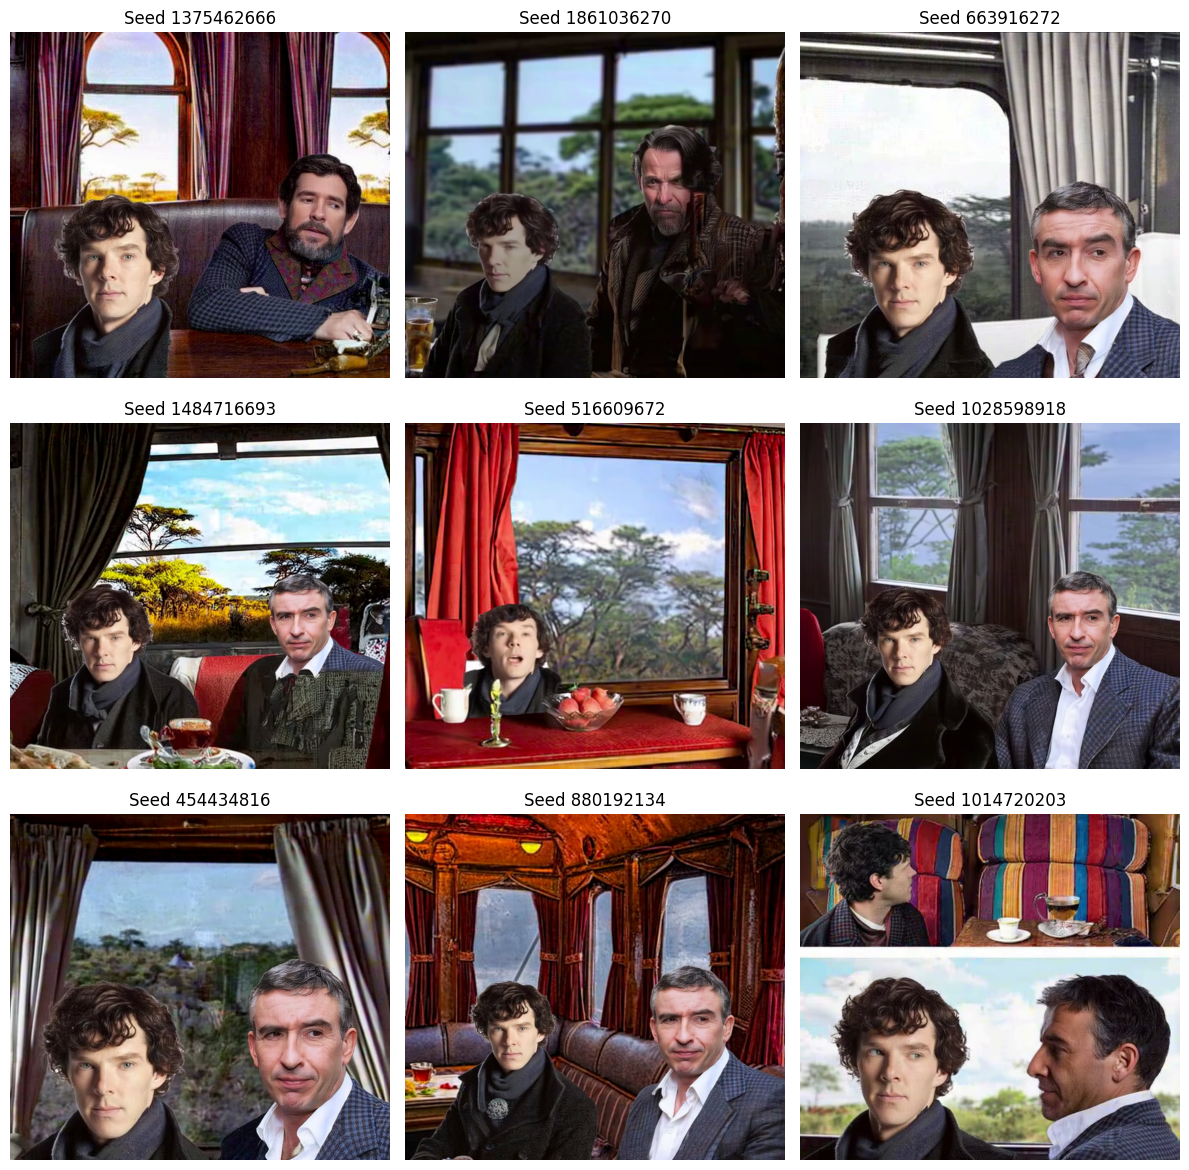

In [ ]:
results_dict_temp = {}
for i in range(9):
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=256, seed=seed, crop_face_detect=True, use_rembg=True,
        cache_results=False, cache_layers=['transformer_blocks.2'], 
        use_attention_masking=['no_cross_control_latents'], 
        control_indices=[0], latent_indices=[3], max_chara=5,
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    results_dict_temp[i] = {
        'seed' : seed,
        'result_img': result_imgs[0], 'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, (key, value) in enumerate(results_dict_temp.items()):
    ax[i // 3, i % 3].imshow(value['result_img'])
    ax[i // 3, i % 3].set_title(f"Seed {value['seed']}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

# results_dict_temp[8]['result_img'].save(Path("tmp") / f"{story_num}/{shot_num-1}_0.png")
# results_dict_temp[8]['debug_img'].save(Path("tmp") / f"{story_num}/debug/{shot_num-1}_0.png")

In [ ]:
outputs_root = Path("/groups/chenchen/patrick/ViStoryBench/outputs/")
story_num = 17
shutil.copytree(
    f"/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/tmp/{story_num}", 
    outputs_root / f"whisperer/v3_3_step6000/en/20251028_232847_v2/{story_num}", 
    dirs_exist_ok=True
)
# shutil.copytree(
#     "/lustre/fs1/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v3_3_step6000/en/20251028_232847", 
#    "/lustre/fs1/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v3_3_step6000/en/20251028_232847_v2",
#     dirs_exist_ok=True
# )

In [ ]:
import time

trials = 10
trials_time = []

idx = 44
sample = dreambench_plus[idx // 9]
caption_ind = idx % 9
width, height = 1024, 1024

prompt = sample.captions[caption_ind]
c_width = 512
panel_layout = {0: {'bbox': [0.1, 0.1, 0.9, 0.9], 'body': []}}
characters_shot = {0 : {'images' : [sample.image_path]}}

for _ in range(trials):
    start_time = time.time()
    
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=c_width, seed=seed, crop_face_detect=False, use_rembg=False,
        cache_results=False, cache_layers=['transformer_blocks.2'], 
        use_attention_masking=['no_cross_control_latents'], 
        control_indices=[0], latent_indices=[3],
        debug_name=f"{sample.collection_id}-{caption_ind}"
    )

    end_time = time.time()
    trials_time.append(end_time - start_time)

print(f"Avg inference time over {trials} trials: {np.mean(trials_time):.2f} sec")